# Predicción de Series Temporales NN - Multivariate

El artículo completo con la explicación detallada en el blog: http://www.aprendemachinelearning.com/

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

### Cargamos nuestro Dataset

In [162]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


### Cargamos Datos Categóricos: Día y Mes

In [163]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [164]:
df.describe()

,unidades,weekday,month
count,604.000000,604.000000,604.000000
mean,215.935430,2.644040,6.304636
std,75.050304,1.818674,3.312359
min,51.000000,0.000000,1.000000
25%,171.000000,1.000000,3.000000
50%,214.000000,3.000000,6.000000
75%,261.250000,4.000000,9.000000
max,591.000000,6.000000,12.000000


# Preprocesado de los datos

In [ ]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [165]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

[[ 0.          1.         -0.31481487]
 [ 1.          1.         -0.31111115]
 [ 2.          1.         -0.11481488]
 ...
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.25925928]
 [ 4.         11.         -0.48888892]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2,1,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3,1,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4,1,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5,1,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,0,1,-0.344444


## Dividimos en set de Entrenamiento y Validación

In [166]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(597, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,-0.344444


In [167]:
# split into train and test sets
values = newReframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 21) (567,) (30, 1, 21) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward

### Como entradas son 21 columnas (7 pasos por 3 variables)

In [168]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## Entrenamos nuestra máquina

In [169]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_5 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Train on 567 samples, validate on 30 samples
Epoch 1/40
567/567 [==============================] - 0s 769us/step - loss: 0.9168 - mean_squared_error: 1.0901 - val_loss: 0.2777 - val_mean_squared_error: 0.1117
Epoch 2/40
567/567 [==============================] - 0s 232us/step - loss: 0.3147 - mean_squared_error: 0.1677 - val_loss: 0.2270 - val_mean_squared_error: 0.0790
Epoch 3/40
567/567 [===============

## Visualizamos Resultados

30


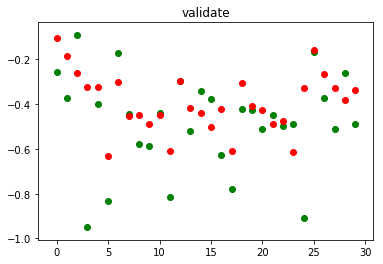

In [183]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


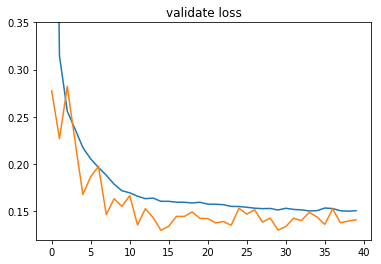

In [186]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

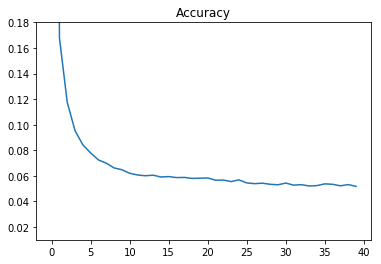

In [191]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [173]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,252.000006,292.846415,-40.846410
1,220.000002,271.207719,-51.207718
2,296.000009,250.841323,45.158686
3,64.999995,233.249007,-168.249012
4,212.999999,233.514626,-20.514627
5,95.999996,150.834429,-54.834433
6,274.999986,239.217922,35.782064
7,201.000000,198.954112,2.045887
8,165.000001,199.531724,-34.531722
9,162.999996,189.600053,-26.600057


In [174]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633332,214.917230,-23.283898
std,57.580817,35.812104,48.738560
min,64.999995,150.834429,-168.249012
25%,169.000000,194.593611,-44.651899
50%,200.499998,209.075410,-24.525737
75%,220.000002,237.060020,1.978475
max,296.000009,292.846415,45.158686


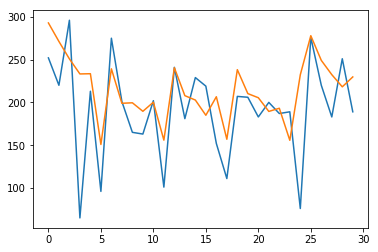

In [192]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [150]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2018-11-16,152,4,11,-0.625926
2018-11-17,111,5,11,-0.777778
2018-11-19,207,0,11,-0.422222
2018-11-20,206,1,11,-0.425926
2018-11-21,183,2,11,-0.511111
2018-11-22,200,3,11,-0.448148
2018-11-23,187,4,11,-0.496296
2018-11-24,189,5,11,-0.488889
2018-11-25,76,6,11,-0.907407


## Preparamos los datos para Test

In [151]:
scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 4.         11.         -0.62592596]
 [ 5.         11.         -0.77777779]
 [ 0.         11.         -0.42222226]
 [ 1.         11.         -0.42592597]
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.44814819]
 [ 4.         11.         -0.49629635]
 [ 5.         11.         -0.48888892]
 [ 6.         11.         -0.9074074 ]
 [ 0.         11.         -0.16666675]
 [ 1.         11.         -0.3740741 ]
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.25925928]
 [ 4.         11.         -0.48888892]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-11-24,4.0,11.0,-0.625926,5.0,11.0,-0.777778,0.0,11.0,-0.422222,1.0,...,-0.425926,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296
2018-11-25,5.0,11.0,-0.777778,0.0,11.0,-0.422222,1.0,11.0,-0.425926,2.0,...,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889
2018-11-26,0.0,11.0,-0.422222,1.0,11.0,-0.425926,2.0,11.0,-0.511111,3.0,...,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407
2018-11-27,1.0,11.0,-0.425926,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,...,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407,0.0,11.0,-0.166667
2018-11-28,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,...,-0.488889,6.0,11.0,-0.907407,0.0,11.0,-0.166667,1.0,11.0,-0.374074
2018-11-29,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,...,-0.907407,0.0,11.0,-0.166667,1.0,11.0,-0.374074,2.0,11.0,-0.511111
2018-11-30,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407,0.0,...,-0.166667,1.0,11.0,-0.374074,2.0,11.0,-0.511111,3.0,11.0,-0.259259


In [153]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(1, 1, 21)
[[[ 4.         11.         -0.49629635  5.         11.
   -0.48888892  6.         11.         -0.9074074   0.
   11.         -0.16666675  1.         11.         -0.3740741
    2.         11.         -0.51111114  3.         11.
   -0.25925928]]]


In [154]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [155]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)
    

pred 0 [[[ 4.         11.         -0.49629635  5.         11.
   -0.48888892  6.         11.         -0.9074074   0.
   11.         -0.16666675  1.         11.         -0.3740741
    2.         11.         -0.51111114  3.         11.
   -0.25925928]]]
pred 1 [[[ 5.         11.         -0.48888892  6.         11.
   -0.9074074   0.         11.         -0.16666675  1.
   11.         -0.3740741   2.         11.         -0.51111114
    3.         11.         -0.25925928  5.         12.
   -0.30600056]]]
pred 2 [[[ 6.         11.         -0.9074074   0.         11.
   -0.16666675  1.         11.         -0.3740741   2.
   11.         -0.51111114  3.         11.         -0.25925928
    5.         12.         -0.30600056  6.         12.
   -0.60506994]]]
pred 3 [[[ 0.         11.         -0.16666675  1.         11.
   -0.3740741   2.         11.         -0.51111114  3.
   11.         -0.25925928  5.         12.         -0.30600056
    6.         12.         -0.60506994  0.         12.
   -0.1

## Re-Convertimos los resultados

In [156]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.30600056], dtype=float32), array([-0.60506994], dtype=float32), array([-0.16298515], dtype=float32), array([-0.31580934], dtype=float32), array([-0.35640854], dtype=float32), array([-0.22789632], dtype=float32), array([-0.21720925], dtype=float32)]


array([[238.37985788],
       [157.63112526],
       [276.99402048],
       [235.73148757],
       [224.76970415],
       [259.46800378],
       [262.35351222]])

## Visualizamos el pronóstico

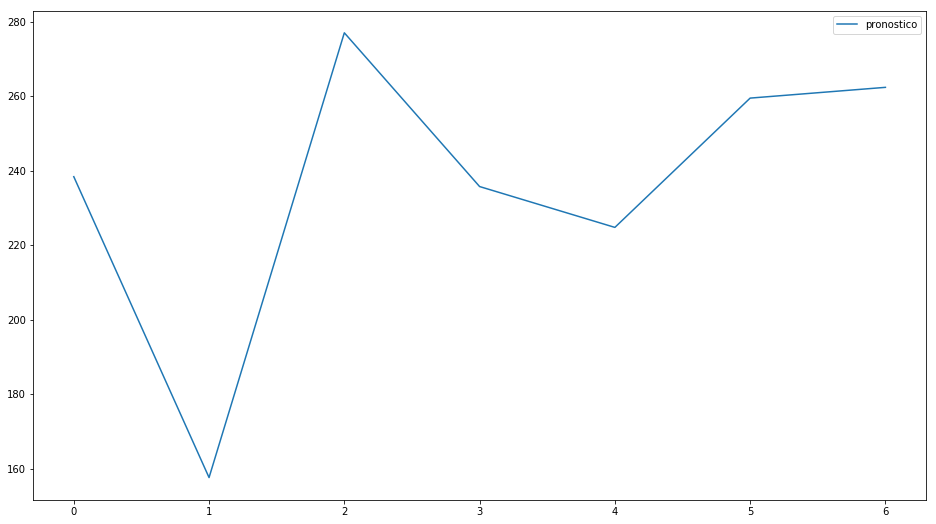

In [157]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_multivariate.csv')

In [158]:
prediccion1SemanaDiciembre

,pronostico
0,238.379858
1,157.631125
2,276.994020
3,235.731488
4,224.769704
5,259.468004
6,262.353512


El artículo completo en www.aprendemachinelearning.com